In [39]:
import tensorflow.compat.v1 as tf1
# import tensorflow as tf2
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
session = tf1.Session(config=config)

2024-10-01 10:42:05.457271: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:3b:00.0, compute capability: 8.0
2024-10-01 10:42:05.458491: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79078 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:5e:00.0, compute capability: 8.0
2024-10-01 10:42:05.459794: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 76688 MB memory:  -> device: 2, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:86:00.0, compute capability: 8.0
2024-10-01 10:42:05.461314: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 76690 MB memory:  -> device: 3, name: NVIDIA A100 80GB PCIe, pci bu

# 관련 연구/논문
* https://etasr.com/index.php/ETASR/article/view/8050
    * 이번 jupyter notebook에서 참고
    * 본 논문은 새로운 아이디어가 아니라 여러 시도를 해보니 이게 성능이 좋더라를 얘기하는 논문이었습니다.
        * VGG16 모델을 사용하여 골절을 분류하는데 이때 아래와 같이 hyperparameter를 설정하면 성능이 가장 좋다고 하여 참고
            * EPOCHS = 30
            * Learning rate = 0.0001
            * Batch size = 32
    * YOLOv8을 활용하여 Localization 진행하는데 이건 추후에 다룰 예정입니다.


* https://www.sciencedirect.com/science/article/pii/S1746809424000533
    * 찜만 해놓은 상태 아직 읽어보진 않았습니다.

# 목차
* **0. 데이터 호출**
* **1. 학습하기 위한 데이터로 변환**
* **2. 데이터 전처리를 위한 VGG16 모델 활용하여 골절 분류**
* **3. 학습한 모델을 사용하여 이미지 골절 예측**

# 0. 데이터 호출
### 0.1 이미지 데이터 불러오기

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

normal_dir = '/home/nas/data/eunju/dataset/FracAtlas/images/Non_fractured/'
abnormal_dir = '/home/nas/data/eunju/dataset/FracAtlas/images/Fractured/'

def count_and_display_images(directory):
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    total_images = len(image_files)
    example_image = image_files[0] if total_images > 0 else None
    return total_images, example_image

normal_count, normal_example = count_and_display_images(normal_dir)
abnormal_count, abnormal_example = count_and_display_images(abnormal_dir)

### 0.2 이미지 특성 데이터 불러오기

In [72]:
import pandas as pd

data = pd.read_csv("./data/dataset.csv")
data

,image_id,hand,leg,hip,shoulder,mixed,hardware,multiscan,fractured,fracture_count,frontal,lateral,oblique
0,IMG0000000.jpg,0,1,0,0,0,0,1,0,0,1,1,0
1,IMG0000001.jpg,0,1,0,0,0,0,1,0,0,1,1,0
2,IMG0000002.jpg,0,1,0,0,0,0,1,0,0,1,1,0
3,IMG0000003.jpg,0,1,0,0,0,0,1,0,0,0,1,1
4,IMG0000004.jpg,0,1,0,0,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4078,IMG0004375.jpg,1,0,0,0,0,0,0,1,1,0,1,0
4079,IMG0004376.jpg,1,0,0,0,0,0,0,1,1,1,0,0
4080,IMG0004383.jpg,0,1,0,0,0,0,0,0,0,1,0,0
4081,IMG0004388.jpg,0,1,0,0,0,0,0,0,0,0,1,0


---

# 1. 학습하기 위한 데이터로 변환

### 1.1 Input Data
* <span style="color: #2D3748; background-color:#fff5b1;">이미지 데이터를 npy 형식으로 변환 (numpy 배열)</span>
* <U>Premature end of JPEG file</U>
    * https://github.com/ultralytics/yolov5/issues/916
    * 손상된 이미지 파일 존재, 하지만 학습에 문제되지는 않는다 함.
    

In [31]:
import os
import cv2
import numpy as np

image_folder = './data/All_sorted_dataset'
output_file = 'allnpy224'

image_data = []

for filename in os.listdir(image_folder):
    if filename.endswith('.jpg'):
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, (224, 224))  # VGG16 모델을 위해 224x224로 리사이즈
        image_data.append(img_resized)

image_data_array = np.array(image_data)  # 리스트를 NumPy 배열로 변환
np.save(output_file, image_data_array)  # npy 파일로 저장

# npy 데이터 load 후 shape 출력
All_npy_224 = np.load("./allnpy224.npy")
print(All_npy_224.shape)

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

(4083, 224, 224)


### 1.2 Label Data
* dataset csv 파일에서 fractured 컬럼만 추출

In [73]:
Label_data = data["fractured"]
print(Label_data)

0       0
1       0
2       0
3       0
4       0
       ..
4078    1
4079    1
4080    0
4081    0
4082    0
Name: fractured, Length: 4083, dtype: int64


### 2. 데이터 전처리를 위한 VGG16 모델 활용하여 골절 분류
* 기초적인 모델 학습 과정과 결과를 토대로 데이터 전처리 진행

##### 2.1 VGG16 모델 구현

* <span style="color: #2D3748; background-color:#fff5b1;">정상 데이터가 골절에 비해 너무 많아, 전부 정상으로 인식하는 경우 Validation_accuracy가 고정</span>될 수 있다고 생각하여 <U>Augmentation</U> 진행

In [66]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

data = All_npy_224
labels = Label_data

data = data.astype('float32') / 255.0

data = np.expand_dims(data, axis=-1)

labels = to_categorical(labels, num_classes=2)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

vgg16_base = VGG16(weights=None, include_top=False, input_shape=(224, 224, 1))
model = Sequential()
model.add(vgg16_base)  # VGG16 모델 추가
model.add(Flatten())   # VGG16 출력값을 평탄화
model.add(Dense(256, activation='relu'))  # 완전 연결 계층 추가
model.add(Dense(2, activation='softmax'))  # 출력층 (2개 클래스: 골절과 비골절)

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"테스트 정확도: {test_acc * 100:.2f}%")


Epoch 1/40
103/103 [==============================] - 8s 71ms/step - loss: 0.5237 - accuracy: 0.8175 - val_loss: 0.4753 - val_accuracy: 0.8237
Epoch 2/40
103/103 [==============================] - 7s 68ms/step - loss: 0.4747 - accuracy: 0.8246 - val_loss: 0.4717 - val_accuracy: 0.8237
Epoch 3/40
103/103 [==============================] - 7s 69ms/step - loss: 0.4735 - accuracy: 0.8246 - val_loss: 0.4802 - val_accuracy: 0.8237
Epoch 4/40
103/103 [==============================] - 7s 68ms/step - loss: 0.4714 - accuracy: 0.8246 - val_loss: 0.4748 - val_accuracy: 0.8237
Epoch 5/40
103/103 [==============================] - 7s 70ms/step - loss: 0.4698 - accuracy: 0.8246 - val_loss: 0.4691 - val_accuracy: 0.8237
Epoch 6/40
103/103 [==============================] - 7s 71ms/step - loss: 0.4697 - accuracy: 0.8246 - val_loss: 0.4675 - val_accuracy: 0.8237
Epoch 7/40
103/103 [==============================] - 7s 70ms/step - loss: 0.4706 - accuracy: 0.8246 - val_loss: 0.4679 - val_accuracy: 0.8237

* loss값 비교

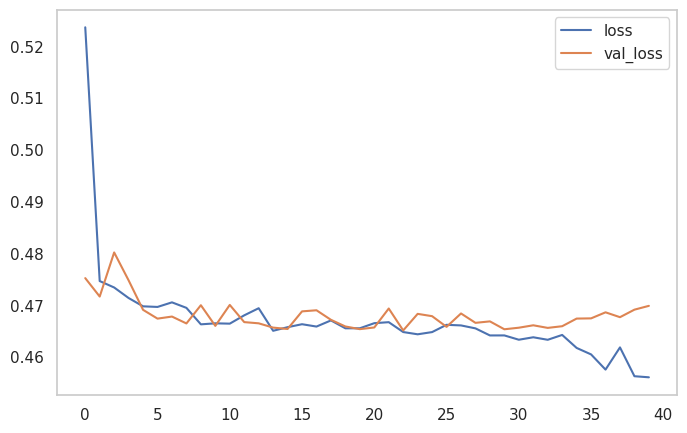

(<matplotlib.legend.Legend at 0x7f19722ea100>, None, None)

In [70]:
plot_target = ['loss', 'val_loss']
plt.figure(figsize=(8,5))
for each in plot_target:
    plt.plot(history.history[each], label = each)
plt.legend(), plt.grid(), plt.show()

##### 2.2 Data Augmentation
* ImageDataGenerator 사용하여 증강
* 변화를 크게 하니 골절 부분이 가려지는 데이터가 생겨 변화를 적게 줌.

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter

# 데이터셋 확인 (정상 vs 골절 이미지 수 비교)
class_counts = Counter(Label_data)
normal_count = class_counts[0]  # 정상 이미지 개수
fracture_count = class_counts[1]  # 골절 이미지 개수

print(f"정상 이미지 수: {normal_count}")
print(f"골절 이미지 수: {fracture_count}")

# 증강할 골절 이미지 수 계산 (정상 이미지 수와 맞추기 위해 필요한 추가 이미지 수)
images_needed = normal_count - fracture_count
print(f"추가로 필요한 골절 이미지 수: {images_needed}")

# 골절 이미지만 추출 (레이블이 1인 것만 필터링)
fracture_images = All_npy_224[np.argmax(labels, axis=1) == 1]
fracture_labels = labels[np.argmax(labels, axis=1) == 1]

# ImageDataGenerator 설정 (증강 옵션 적용)
datagen = ImageDataGenerator(
    rotation_range=15,        # 회전
    width_shift_range=0.1,    # 좌우 이동
    height_shift_range=0.1,   # 상하 이동
    shear_range=0.1,          # 전단 변환
    zoom_range=0.1,           # 확대/축소
    horizontal_flip=True,     # 수평 반전
    fill_mode='constant'       # 빈 공간 채우기
)

# 필요한 추가 이미지를 생성
fracture_images = np.expand_dims(fracture_images, axis=-1)
fracture_gen = datagen.flow(fracture_images, fracture_labels, batch_size=32, shuffle=False)

# 추가로 생성한 골절 이미지와 레이블을 저장할 리스트
augmented_images = []
augmented_labels = []

# 필요로 하는 수만큼 이미지 생성
for i in range(images_needed // 32 + 1):
    batch_images, batch_labels = fracture_gen.next()
    augmented_images.extend(batch_images)
    augmented_labels.extend(batch_labels)
    if len(augmented_images) >= images_needed:
        break

# numpy 배열로 변환 및 채널 차원 추가
augmented_images = np.array(augmented_images[:images_needed])

# 원본 데이터에 추가 (증강된 데이터를 원본 데이터와 결합)
data = All_npy_224
data = np.expand_dims(data, axis=-1)
X_train_balanced = np.concatenate([data, augmented_images], axis=0)
y_train_balanced = np.concatenate([labels, augmented_labels], axis=0)

# 증강된 데이터셋의 클래스 분포 확인
new_class_counts = Counter(np.argmax(y_train_balanced, axis=1))
print(f"증강 후 정상 이미지 수: {new_class_counts[0]}")
print(f"증강 후 골절 이미지 수: {new_class_counts[1]}")

정상 이미지 수: 3366
골절 이미지 수: 717
추가로 필요한 골절 이미지 수: 2649
증강 후 정상 이미지 수: 3366
증강 후 골절 이미지 수: 3316


* 증강 후 정상, 골절 데이터 수 비교

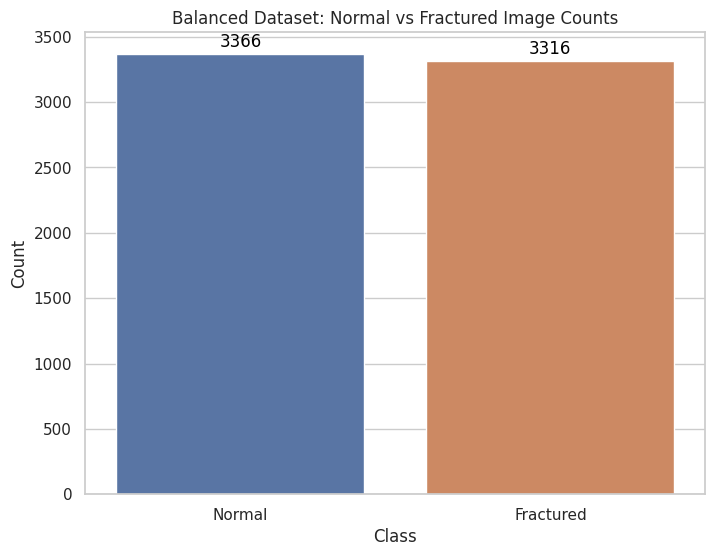

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 분포 시각화 (정상과 골절 이미지 수 비교)
labels = ['Normal', 'Fractured']
counts = [new_class_counts[0], new_class_counts[1]]

# Seaborn 스타일 적용
sns.set(style="whitegrid")


# 막대 그래프 그리기
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=labels, y=counts)

# 각 막대 위에 개수 표시
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Balanced Dataset: Normal vs Fractured Image Counts')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


* 증강한 데이터 확인

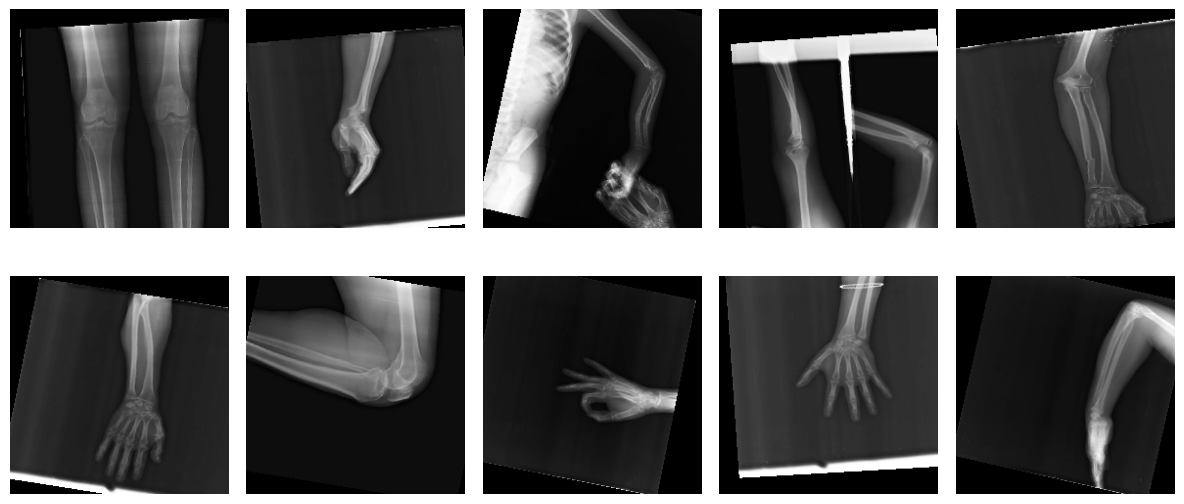

In [96]:
import matplotlib.pyplot as plt

# 증강된 이미지 중 10개를 선택하여 시각화 (2행 5열)
def plot_augmented_images(augmented_images):
    plt.figure(figsize=(12, 6))  # 전체 그래프 크기 설정
    for i in range(10):
        plt.subplot(2, 5, i+1)  # 2행 5열로 출력
        img = augmented_images[i].squeeze()  # 채널 차원 제거 (그레이스케일 이미지인 경우)
        plt.imshow(img, cmap='gray')  # 그레이스케일 이미지로 출력
        plt.axis('off')  # 축 숨기기
    plt.tight_layout()
    plt.show()

# 10개의 증강된 이미지 시각화
plot_augmented_images(augmented_images)


### 2.3 Augmentation한 데이터를 VGG16 모델로 학습
* <span style="color: #2D3748; background-color:#fff5b1;">Validation Loss가 계속 증가하는 문제 발생</span>
    * <U>증강할 때 조금씩만 변하게</U> 했더니 비슷한 데이터가 많아져서 <span style="color: #2D3748; background-color:#fff5b1;">train data에 과적합</span> 되서 그런것 같음. 
    * <U>Dropout</U> 사용해서 과적합 방지해보겠습니다.

In [97]:
# 학습용 데이터셋을 새로 분리 (증강된 데이터를 포함하여)
X_train, X_test, y_train, y_test = train_test_split(X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)


vgg16_base = VGG16(weights=None, include_top=False, input_shape=(224, 224, 1))
model = Sequential()
model.add(vgg16_base)  # VGG16 모델 추가
model.add(Flatten())   # VGG16 출력값을 평탄화
model.add(Dense(256, activation='relu'))  # 완전 연결 계층 추가
model.add(Dense(2, activation='softmax'))  # 출력층 (2개 클래스: 골절과 비골절)

model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"테스트 정확도: {test_acc * 100:.2f}%")

Epoch 1/40
168/168 [==============================] - 13s 73ms/step - loss: 0.5244 - accuracy: 0.7457 - val_loss: 0.4257 - val_accuracy: 0.8085
Epoch 2/40
168/168 [==============================] - 12s 70ms/step - loss: 0.3593 - accuracy: 0.8587 - val_loss: 0.3775 - val_accuracy: 0.8512
Epoch 3/40
168/168 [==============================] - 12s 71ms/step - loss: 0.3260 - accuracy: 0.8745 - val_loss: 0.3767 - val_accuracy: 0.8429
Epoch 4/40
168/168 [==============================] - 12s 71ms/step - loss: 0.3054 - accuracy: 0.8833 - val_loss: 0.3249 - val_accuracy: 0.8751
Epoch 5/40
168/168 [==============================] - 12s 71ms/step - loss: 0.2941 - accuracy: 0.8849 - val_loss: 0.3426 - val_accuracy: 0.8639
Epoch 6/40
168/168 [==============================] - 12s 70ms/step - loss: 0.2854 - accuracy: 0.8907 - val_loss: 0.3411 - val_accuracy: 0.8684
Epoch 7/40
168/168 [==============================] - 12s 71ms/step - loss: 0.2758 - accuracy: 0.8906 - val_loss: 0.3296 - val_accuracy:

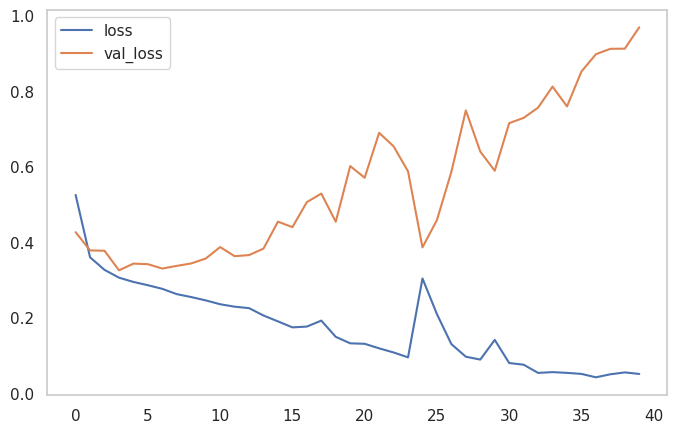

(<matplotlib.legend.Legend at 0x7f17bc0dd7c0>, None, None)

In [98]:
plot_target = ['loss', 'val_loss']
plt.figure(figsize=(8,5))
for each in plot_target:
    plt.plot(history.history[each], label = each)
plt.legend(), plt.grid(), plt.show()

### 2.4 Augmentation한 데이터를 VGG16 + Dropout 모델로 학습
* <span style="color: #2D3748; background-color:#fff5b1;">Validation Loss가 미세하게 감소하다가 증가하는 문제 발생</span>
    * <U>Early Stopping</U> 사용해보겠습니다.

In [100]:
from tensorflow.keras.layers import Dropout

vgg16_base = VGG16(weights=None, include_top=False, input_shape=(224, 224, 1))
model = Sequential()
model.add(vgg16_base)  # VGG16 모델 추가
model.add(Flatten())   # VGG16 출력값을 평탄화
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Dropout 추가: 50%의 뉴런을 비활성화
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"테스트 정확도: {test_acc * 100:.2f}%")

Epoch 1/40
168/168 [==============================] - 13s 75ms/step - loss: 0.5632 - accuracy: 0.7121 - val_loss: 0.4058 - val_accuracy: 0.8482
Epoch 2/40
168/168 [==============================] - 12s 70ms/step - loss: 0.3715 - accuracy: 0.8522 - val_loss: 0.3650 - val_accuracy: 0.8616
Epoch 3/40
168/168 [==============================] - 12s 72ms/step - loss: 0.3305 - accuracy: 0.8750 - val_loss: 0.3533 - val_accuracy: 0.8699
Epoch 4/40
168/168 [==============================] - 12s 70ms/step - loss: 0.3168 - accuracy: 0.8780 - val_loss: 0.3217 - val_accuracy: 0.8758
Epoch 5/40
168/168 [==============================] - 12s 70ms/step - loss: 0.3023 - accuracy: 0.8844 - val_loss: 0.3156 - val_accuracy: 0.8781
Epoch 6/40
168/168 [==============================] - 12s 69ms/step - loss: 0.3013 - accuracy: 0.8833 - val_loss: 0.3232 - val_accuracy: 0.8766
Epoch 7/40
168/168 [==============================] - 12s 71ms/step - loss: 0.2928 - accuracy: 0.8883 - val_loss: 0.3143 - val_accuracy:

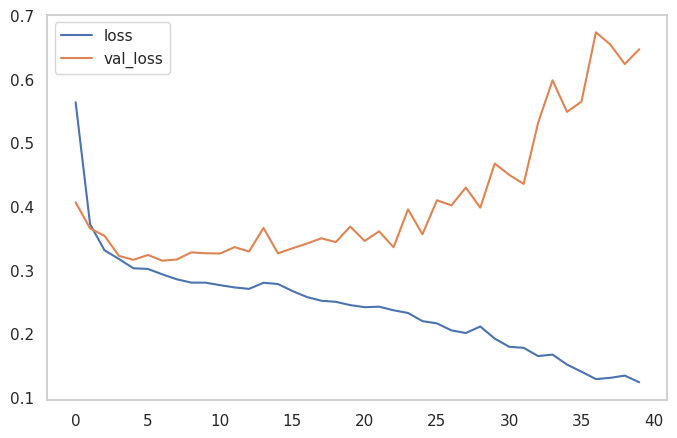

(<matplotlib.legend.Legend at 0x7f1a67847610>, None, None)

In [101]:
plot_target = ['loss', 'val_loss']
plt.figure(figsize=(8,5))
for each in plot_target:
    plt.plot(history.history[each], label = each)
plt.legend(), plt.grid(), plt.show()

### 2.5 Augmentation한 데이터를 VGG16 + Dropout + Early Stopping 모델로 학습
* Epoch : 12에서 13 넘어갈 때 중지

In [102]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

# VGG16 모델 구성
vgg16_base = VGG16(weights=None, include_top=False, input_shape=(224, 224, 1))
model = Sequential()
model.add(vgg16_base)  # VGG16 모델 추가
model.add(Flatten())   # VGG16 출력값을 평탄화
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Dropout 추가: 50%의 뉴런을 비활성화
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping 콜백 설정 (검증 손실이 개선되지 않으면 학습을 중단)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습 (EarlyStopping 콜백 추가)
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"테스트 정확도: {test_acc * 100:.2f}%")


Epoch 1/40
168/168 [==============================] - 13s 72ms/step - loss: 0.5565 - accuracy: 0.7083 - val_loss: 0.4141 - val_accuracy: 0.8392
Epoch 2/40
168/168 [==============================] - 12s 69ms/step - loss: 0.3789 - accuracy: 0.8479 - val_loss: 0.3971 - val_accuracy: 0.8160
Epoch 3/40
168/168 [==============================] - 12s 70ms/step - loss: 0.3370 - accuracy: 0.8702 - val_loss: 0.3394 - val_accuracy: 0.8676
Epoch 4/40
168/168 [==============================] - 12s 70ms/step - loss: 0.3158 - accuracy: 0.8790 - val_loss: 0.3291 - val_accuracy: 0.8736
Epoch 5/40
168/168 [==============================] - 12s 70ms/step - loss: 0.3063 - accuracy: 0.8825 - val_loss: 0.3179 - val_accuracy: 0.8751
Epoch 6/40
168/168 [==============================] - 12s 72ms/step - loss: 0.2981 - accuracy: 0.8877 - val_loss: 0.3155 - val_accuracy: 0.8758
Epoch 7/40
168/168 [==============================] - 12s 70ms/step - loss: 0.2928 - accuracy: 0.8876 - val_loss: 0.3146 - val_accuracy:

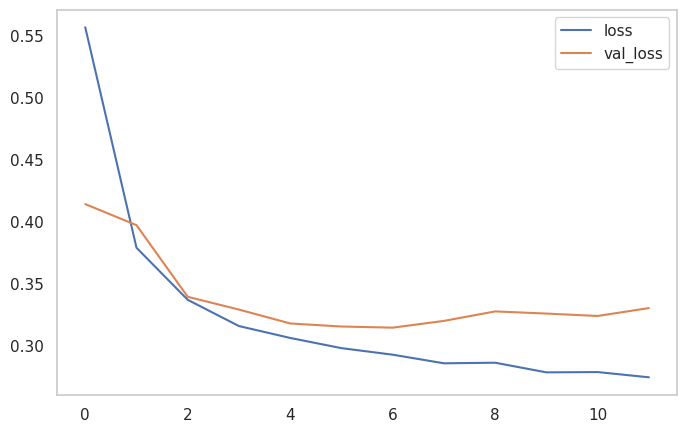

(<matplotlib.legend.Legend at 0x7f1a706116a0>, None, None)

In [103]:
plot_target = ['loss', 'val_loss']
plt.figure(figsize=(8,5))
for each in plot_target:
    plt.plot(history.history[each], label = each)
plt.legend(), plt.grid(), plt.show()

* **실제로 골절인데 정상이라고 인식하는 최악의 상황이 가장 많다니...**
* 나중에 처리 해보겠습니다.

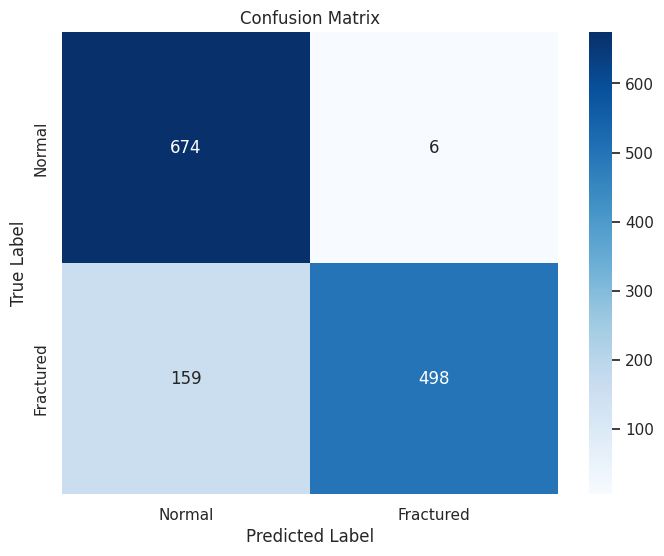

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 모델을 사용하여 예측값 생성
y_pred_probs = model.predict(X_test)  # 확률 값 예측
y_pred = np.argmax(y_pred_probs, axis=1)  # 예측된 클래스 (확률이 가장 높은 클래스를 선택)
y_true = np.argmax(y_test, axis=1)  # 실제 클래스 (one-hot 인코딩된 y_test에서 클래스 인덱스 추출)

# 혼동 행렬 생성
cm = confusion_matrix(y_true, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fractured'], yticklabels=['Normal', 'Fractured'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### 3. 학습한 모델을 사용하여 이미지 골절 예측

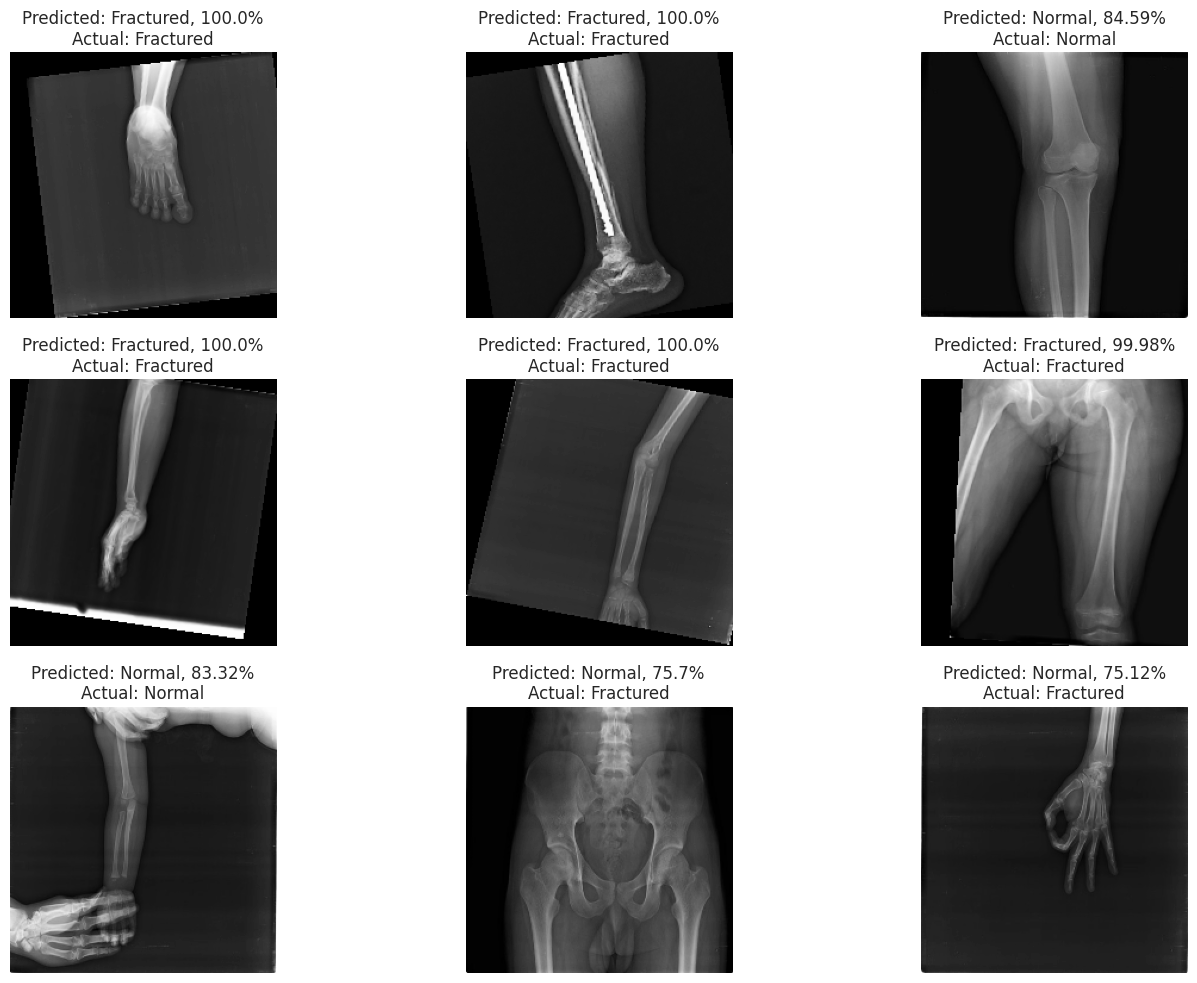

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 예측과 실제 라벨에 대한 정보를 저장할 변수 설정
index_label = {0: 'Normal', 1: 'Fractured'}  # 라벨 인덱스 매핑

# 모델을 사용하여 예측값과 확률 계산
pred_probs = model.predict(X_test)  # 모델이 예측한 확률
pred = np.argmax(pred_probs, axis=1)  # 예측한 클래스 (확률이 가장 높은 클래스 선택)
truth = np.argmax(y_test, axis=1)  # 실제 클래스 (one-hot 인코딩된 y_test에서 인덱스 추출)

# 시각화할 이미지 갯수 설정 (최대 9개)
num_images = 9

# Subplot을 3x3 형식으로 설정
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
index = 0

for i in range(3):
    for j in range(3):
        if index < num_images:
            image = X_test[index]  # X_test에서 이미지를 가져옴
            image = np.squeeze(image)  # 차원을 축소하여 2D 형태로 만듦 (그레이스케일일 경우)
            
            # 이미지를 시각화
            axes[i][j].imshow(image, cmap='gray')  # 그레이스케일 이미지로 표시
            
            # 예측된 라벨과 실제 라벨을 표시
            axes[i][j].set_title(
                "Predicted: {}, {}%\nActual: {}".format(
                    index_label[pred[index]], 
                    round(np.max(pred_probs[index]) * 100, 2),  # 예측 확률 표시
                    index_label[truth[index]]  # 실제 클래스
                )
            )
            
            axes[i][j].axis("off")
            
            index += 1

plt.tight_layout()
plt.show()
